In [18]:
# load variables and configurations

%matplotlib inline 
import matplotlib.pyplot as plt

import csv

from utils import convert_symbol_into_usdt, date_to_string
from config import USDT_SYMBOLS, DATA_FOLDER_NAME_READ
abstract_feature_symbols = ["diff_domains"] #, "diff_domains_weighted"]


nb_symbol_limit = 30 # to delerte
nb_symbol_to_currencies_graph_in_bokeh = 3
matplotlib_sequence_length_limit = 6000 # "nolimit"
bokeh_sequence_length_limit = "nolimit" # "nolimit"
bucket_middle = 0.003 # 0.004





def get_evaluation_periods(start_timestamp, end_timestamp, period_length_in_s):
    evaluation_periods = []
    need_to_break = False
    for start_t in range(start_timestamp, end_timestamp, period_length_in_s):
        end_t = start_t + period_length_in_s
        if end_t > end_timestamp:
            need_to_break = True
        evaluation_periods.append({'start': start_t, 'end': end_t})

        if need_to_break:
            break
    return evaluation_periods



# estimation_end_date "nolimit" available

# 2 stables weeks
# estimation_start_date = 1522447200 # 31th of March 2018
# estimation_end_date = 1523321940 # 10th of April 2018

# 1 decreasing week
# estimation_start_date = 1521846000 # 24th of Match 2018
# estimation_end_date = 1522447200 # 31th of March 2018

# 1 growing week   - week with amazing results
#estimation_start_date = 1523321940 # 10th of March 2018
#estimation_end_date = 1523916000 # 17th of April 2018

# 1 growing week
# estimation_start_date = 1523916000 # 17th of March 2018
# estimation_end_date = 1524348000 # 22th of April 2018

# december 2017
# estimation_start_date = 1512082800
# estimation_end_date = 1514156400

# 4 months
# estimation_start_date = 1518822000
# estimation_end_date = 1526810400

# 4 months v2
estimation_start_date = 1518822000
estimation_end_date = 1526810400



# semaine des tests de la premiere implementation de l'algo
bot_test_period_start = 1526378400
bot_test_period_end = 1526810400
def get_evaluation_periods_during_bot_test_period(): # all last a day
    one_day_in_s = 24 * 3600
    return get_evaluation_periods(bot_test_period_start, bot_test_period_end, one_day_in_s)



selected_symbols = USDT_SYMBOLS[:nb_symbol_limit]






In [3]:
# load disk data, SLOW

def get_dict_symbol_rows():
    dict_symbol_rows = {}
    for idx, symbol in enumerate(selected_symbols):
        with open("{}/binance_{}_only_start_price.csv".format(DATA_FOLDER_NAME_READ, symbol), newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            rows = [row for row in spamreader]
                
            dict_symbol_rows[symbol] = rows

        if idx <= 2:
            print("testing if we can read the files correctly")
            print(rows[0])
            print()
    return dict_symbol_rows

dict_symbol_rows = get_dict_symbol_rows()


testing if we can read the files correctly
['1518822000000', '10179.95']

testing if we can read the files correctly
['1518822000000', '942.61247025']

testing if we can read the files correctly
['1518822000000', '1.112668535']



In [4]:
# compute timestamps, prices and diffs

import numpy as np
from collections import defaultdict

mask_length = 60
prices_mask = np.zeros((mask_length,), dtype='float')
prices_mask[mask_length - 1] = -1
prices_mask[0] = 1
timestamps_mask = np.zeros((mask_length,), dtype='float')
timestamps_mask[0] = 1


def get_bucket(value):
    if value <= -bucket_middle:
        return -1
    elif value >= -bucket_middle and value <= bucket_middle:
        return 0
    elif value >= bucket_middle:
        return 1
    

def get_x_y(): 
    d_features_graph_scale = defaultdict(lambda: 1.0) # 1 divided by the first price obtained
    d_symbol_timestamps = {} # timestamps in seconds
    d_symbol_prices = {} # in USDT
    d_symbol_diff = {} # difference of price
    d_symbol_bucket = {} # -1 or 0 or 1
    for idx, symbol in enumerate(selected_symbols):
        timestamps = []
        prices = []
        rows = dict_symbol_rows[symbol]
        for row in rows:
            timestamp = int(row[0]) / 1000
            price = float(row[1])
            timestamps.append(timestamp)
            prices.append(price)

        d_symbol_prices[symbol] = np.array(prices, dtype='float')

        timestamps = np.convolve(timestamps, timestamps_mask, mode = 'valid')
        d_symbol_timestamps[symbol] = timestamps

        diff = np.convolve(prices, prices_mask, mode = 'valid')
        #std = np.std(diff)
        #diff /= std
        d_features_graph_scale[symbol] = 1.0 / prices[0]
        d_symbol_diff[symbol] = diff

        buckets = [get_bucket(value / prices[0]) for value in diff] # ERROR: avaiat oublie de divise par prices[0], dependences ici, car mon code fait 4 trucs en meme temps
        d_symbol_bucket[symbol] = buckets

        if idx == 0:
            print(timestamps.shape)
        assert(timestamps.shape[0] == d_symbol_timestamps["BTCUSDT"].shape[0])
    return d_symbol_timestamps, d_symbol_prices, d_symbol_diff, d_symbol_bucket, d_features_graph_scale


d_symbol_timestamps, d_symbol_prices, d_symbol_diff, d_symbol_bucket, d_features_graph_scale = get_x_y()
    


(133441,)


In [5]:
# compute diff_domain and its weighted version

# ERROR if "diff_domains" in selected_symbols:/ ### UTILISER FONCTION DU MEME NOM POUR PLUSIEURS CONTENT FAIT TACHE ICI !!
#     selected_symbols.remove("diff_domains")
    
    
# diff_domains: sum of buckets divided by number of symbols, value in [-1, 1]
def get_diff_domains_and_weighted_version(s_timestamps):
    diff_domains = np.zeros(s_timestamps.shape)
    #diff_domains_weighted = np.zeros(s_timestamps.shape)
    for symbol in selected_symbols:
        diff_domains += d_symbol_bucket[symbol]
        #weight = d_symbol_weight[symbol]
        #diff_domains_weighted += [x * weight for x in d_symbol_bucket[symbol]]

    diff_domains /= len(selected_symbols)
    d_features_graph_scale["diff_domains"] = 1.0 / 100.0

    #sum_weights = sum([d_symbol_weight[s] for s in d_symbol_weight])
    #diff_domains_weighted /= sum_weights
    #d_features_graph_scale["diff_domains_weighted"] = 1.0 / 100.0
    
    print(diff_domains[0:10])
    #print(diff_domains_weighted[0:10])

    return diff_domains #, diff_domains_weighted


diff_domains = get_diff_domains_and_weighted_version(d_symbol_timestamps["BTCUSDT"])

d_symbol_timestamps["diff_domains"] = d_symbol_timestamps["BTCUSDT"]
d_symbol_diff["diff_domains"] = diff_domains

#d_symbol_timestamps["diff_domains_weighted"] = d_symbol_timestamps["BTCUSDT"] NOT COMPUTED PROPERLY
#d_symbol_diff["diff_domains_weighted"] = diff_domains_weighted



[-0.2        -0.06666667 -0.2        -0.2        -0.5        -0.26666667
 -0.3        -0.4        -0.56666667 -0.56666667]


In [ ]:
# display matpltolib graphs

symbols_to_graph_with_matplotlib = abstract_feature_symbols + selected_symbols

# x-axis: number of days
def display_matplotlib_graphs(d_symbol_timestamps, d_symbol_diff, matplotlib_sequence_length_limit):
    for symbol in symbols_to_graph_with_matplotlib:
        x = d_symbol_timestamps[symbol]
        y = d_symbol_diff[symbol]
        
        if matplotlib_sequence_length_limit != "nolimit":
            x = x[:matplotlib_sequence_length_limit]
            y = y[:matplotlib_sequence_length_limit]

        x_per_day = [x_datum / float(24 * 3600) for x_datum in x]
        plt.title(symbol)
        plt.plot(x_per_day, y, c='blue')
        plt.show()
        
display_matplotlib_graphs(d_symbol_timestamps, d_symbol_diff, matplotlib_sequence_length_limit)
    

In [6]:
# add functions display bokeh graphs

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

from utils import CATEGORY_20_PALETTE, get_palette_color, CATEGORY_3_DASH_PATTERNS, get_dash_pattern
    
    

symbols_to_graph_in_bokeh = abstract_feature_symbols + selected_symbols[:nb_symbol_to_currencies_graph_in_bokeh]

def display_bokeh_graphs(symbols, d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit, is_scaled):
    fig = figure(title="WARNING: scaled features", x_axis_type="datetime")
    for idx, symbol in enumerate(symbols):
        x = d_symbol_timestamps[symbol]
        y = d_symbol_diff[symbol]

        if bokeh_sequence_length_limit != "nolimit":
            x = x[:bokeh_sequence_length_limit]
            y = y[:bokeh_sequence_length_limit]
            
        x = [t * 1000 for t in x] # bokeh needs ms
        
        scale_factor = d_features_graph_scale[symbol] if is_scaled else 1.0
        y = [yi * scale_factor for yi in y]
        fig.line(x, y, line_width=3, legend="{} diff scaled {} times".format(symbol, scale_factor), line_dash=get_dash_pattern(idx), color=get_palette_color(idx))
    show(gridplot([[fig]], plot_width=int(1262 * 0.95), plot_height=int(780 * 0.95)))
    output_file("./graph_features.html", title="")
    


In [ ]:
# display all currencies bokeh graph 

is_scaled = True
display_bokeh_graphs(symbols_to_graph_in_bokeh, d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit, is_scaled)


In [ ]:
# display "diff_domains" bokeh graph

is_scaled = False
display_bokeh_graphs(["diff_domains"], d_symbol_timestamps, d_symbol_diff, bokeh_sequence_length_limit, is_scaled)


In [12]:
# functions to evaluate our trading algorithm

from collections import defaultdict


# IOTAUSDT
# lazy_wins = -0.5312443952377469
# wins = 0.11148217232292319
# nb_bets = 44


def display_histogram_wins(symbol, win_array):
    if len(win_array) > 0:
        plt.title('Histogram of wins for {}'.format(symbol))
        plt.xlabel('Relative win'.format(np.median(win_array)))
        plt.ylabel('Numbr of wins')
        plt.hist(win_array, bins=50, range=(-0.02, 0.02))
        plt.show()
    
    
def try_winning(buy_trigger, display_all_currencies_graphs, \
                symbol, start_date, end_date, all_bets, all_won_sums, print_log):    
    #d_symbol_minutes_before_retrying = defaultdict(int)
    wins = 0.0 # sum of relative wins
    keep_for_x_minutes = 10
    dont_touch_same_currency_for_n_minutes = 50
    #buy_trigger = 0.86 # debug 0.75

    nb_debug_msgs = 100 # debug
    
    is_first_timestamp_index_set = False
    first_timestamp_index = 0
    last_timestamp_index = 0

    nb_bets = 0
    won_bets = 0
    win_array = []
    minutes_before_retrying = 0
    for idx, t in enumerate(d_symbol_timestamps[symbol][:-keep_for_x_minutes]): # on joue sur 60 seconds
        if not (t >= start_date):
            continue
            
        if not (end_date == "nolimit" or t <= end_date):
            continue
            
        minutes_before_retrying = max(0, minutes_before_retrying - 1)
        
        # computed first timestamps index where we works according to 'start_date'
        if not is_first_timestamp_index_set:
            first_timestamp_index = idx
            is_first_timestamp_index_set = True
            
        last_timestamp_index = idx

        # first condition to decide to buy
        diff_domain = d_symbol_diff["diff_domains"][idx]
        if not (diff_domain >= buy_trigger): ### todo problem BUG pk diff et pas relative diff
            continue
            
        if not minutes_before_retrying == 0:
            continue
            
        # second condition to decide to buy
        bucket = d_symbol_bucket[symbol][idx]
        condition_to_buy = (bucket == 1 and d_symbol_diff[symbol][idx] <= 0.005) # on fait que achete 1 pour le moment
        if not condition_to_buy: 
            continue
            
        # buying
        win = d_symbol_prices[symbol][idx + keep_for_x_minutes] - d_symbol_prices[symbol][idx]
        win /= d_symbol_prices[symbol][idx] #  relative win
        if win > 0: 
            won_bets += 1
        win_array.append(win)
        if nb_debug_msgs > 0:
            nb_debug_msgs -= 1
#             print(idx, win)
            #print("{:.4f}".format(float(win)))
        wins += win 
        nb_bets +=1
        minutes_before_retrying = dont_touch_same_currency_for_n_minutes
        

    price_beginning = d_symbol_prices[symbol][first_timestamp_index]
    price_end = d_symbol_prices[symbol][last_timestamp_index] # ERROR: avant c'etais -1 qui risquait de pas passer si on 
                                                                # changeait la end date du fichier, introduisant une 
                                                                # FAR DEPENDENCY
    lazy_wins = (price_end - price_beginning) / price_beginning
        
    if print_log:
        print(symbol)
        print("lazy_wins = {}".format(lazy_wins))
        print("wins = {}".format(wins))
        print("nb_bets = {}".format(nb_bets))
        print("won_bets = {}".format(won_bets))
        if nb_bets > 0:
            print("percentage of bets won = {:.2f}".format(won_bets / float(nb_bets)))
    if display_all_currencies_graphs:
        display_histogram_wins(symbol, win_array)
    if print_log or display_all_currencies_graphs:
        print("_____________________________________________________________________ \n")
    all_bets.extend(win_array)
    
    return all_won_sums + wins
    
    
def try_winning_with_all_cryptos(array_buy_trigger, \
                                 start_date, end_date, display_all_currencies_graphs, print_log):
    for buy_trigger in array_buy_trigger:
        print("buy_trigger = {}, start_date = {}, end_date= {}" \
              .format(buy_trigger, start_date, end_date))
        all_won_sums = 0
        all_bets = []

        for symbol in selected_symbols:
            all_won_sums = try_winning(buy_trigger, \
                                       display_all_currencies_graphs, symbol, \
                                       start_date, end_date, all_bets, all_won_sums, print_log)

        display_histogram_wins("All currencies buy when diff_domains reaches {}" \
                               .format(buy_trigger), all_bets)

        nb_won_bets = 0
        for win in all_bets:
            if win >= 0:
                nb_won_bets +=1
        print("nb_of_bets = {}".format(len(all_bets)))
        print("ratio of won bets = {}".format(nb_won_bets / float(len(all_bets))))
        print("median wins = {}".format(np.median(all_bets)))
        print("all_won_sums = {}".format(all_won_sums))
        print("_____________________________________________________________________ \n")


def study_all_days_bot_test_periods(buy_trigger):
    display_all_currencies_graphs = False
    print_log = False
    for row in get_evaluation_periods_during_bot_test_period():
        start = row['start']
        end = row['end']
        try_winning_with_all_cryptos([buy_trigger], start, end, display_all_currencies_graphs, print_log)

    try_winning_with_all_cryptos([buy_trigger], bot_test_period_start, bot_test_period_end, display_all_currencies_graphs, print_log)
    
    
def study_all_weeks_all_periods(array_buy_trigger):
    for buy_trigger in array_buy_trigger:
        display_all_currencies_graphs = False
        print_log = False

        one_week_in_s = 7 * 24 * 3600
        for row in get_evaluation_periods(estimation_start_date, estimation_end_date, one_week_in_s):
            start = row['start']
            end = row['end']
            try_winning_with_all_cryptos([buy_trigger], start, end, display_all_currencies_graphs, print_log)

        try_winning_with_all_cryptos([buy_trigger], estimation_start_date, estimation_end_date, display_all_currencies_graphs, print_log)
        

def study_all_period(array_buy_trigger):
    for buy_trigger in array_buy_trigger:
        display_all_currencies_graphs = False
        print_log = False
        
        try_winning_with_all_cryptos([buy_trigger], estimation_start_date, estimation_end_date, display_all_currencies_graphs, print_log)




buy_trigger = 0.5, start_date = 1523321940, end_date= 1523916000


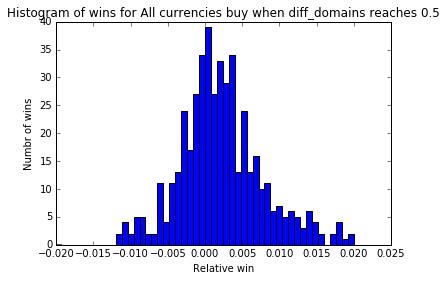

nb_of_bets = 479
ratio of won bets = 0.6576200417536534
median wins = 0.0019330704189139552
all_won_sums = 1.3176695949456003
_____________________________________________________________________ 

buy_trigger = 0.6, start_date = 1523321940, end_date= 1523916000


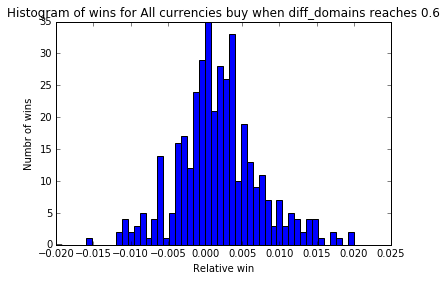

nb_of_bets = 400
ratio of won bets = 0.65
median wins = 0.0017550115203560242
all_won_sums = 0.9545004824118286
_____________________________________________________________________ 

buy_trigger = 0.9, start_date = 1523321940, end_date= 1523916000


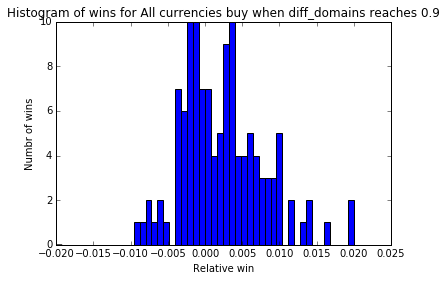

nb_of_bets = 126
ratio of won bets = 0.6190476190476191
median wins = 0.002335354405396707
all_won_sums = 0.38723144738833354
_____________________________________________________________________ 

buy_trigger = 0.91, start_date = 1523321940, end_date= 1523916000


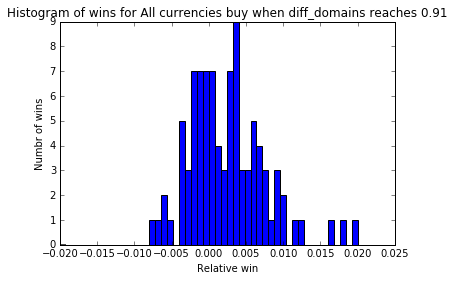

nb_of_bets = 97
ratio of won bets = 0.6494845360824743
median wins = 0.002610027767582549
all_won_sums = 0.32227776587641893
_____________________________________________________________________ 

buy_trigger = 0.92, start_date = 1523321940, end_date= 1523916000


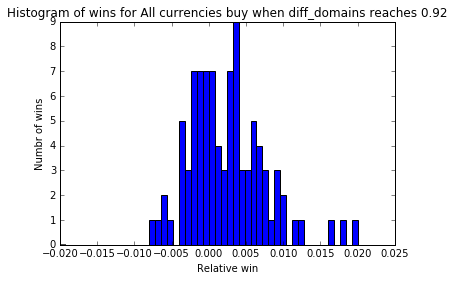

nb_of_bets = 97
ratio of won bets = 0.6494845360824743
median wins = 0.002610027767582549
all_won_sums = 0.32227776587641893
_____________________________________________________________________ 

buy_trigger = 0.93, start_date = 1523321940, end_date= 1523916000


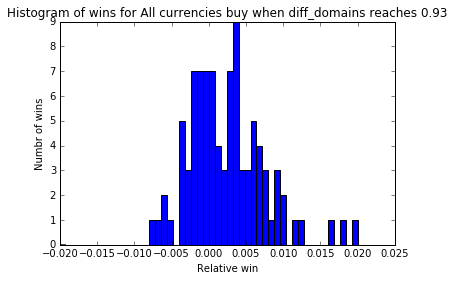

nb_of_bets = 97
ratio of won bets = 0.6494845360824743
median wins = 0.002610027767582549
all_won_sums = 0.32227776587641893
_____________________________________________________________________ 

buy_trigger = 0.95, start_date = 1523321940, end_date= 1523916000


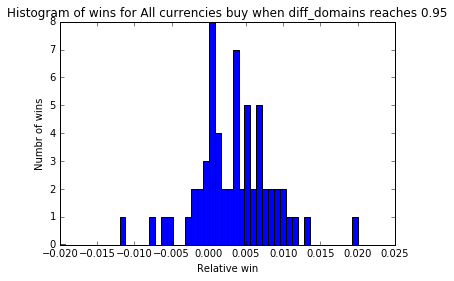

nb_of_bets = 1104
ratio of won bets = 0.6856884057971014
median wins = 0.0024615211656467033
all_won_sums = 3.949601955652543
_____________________________________________________________________ 



In [17]:
# evaluate our trading algorithm


array_buy_trigger = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
#try_winning_with_all_cryptos(array_buy_trigger)


#display_all_currencies_graphs = True
#print_log = False
#try_winning_with_all_cryptos([0.9], estimation_start_date, estimation_end_date, \
#                             display_all_currencies_graphs, print_log) # 0.9 est le best


# buy_trigger = 0.9
# study_all_days_bot_test_periods(buy_trigger)


# array_buy_trigger = [0.9]
# study_all_weeks_all_periods(array_buy_trigger)


array_buy_trigger = [0.5, 0.6, 0.9, 0.91, 0.92, 0.93, 0.95]
study_all_period(array_buy_trigger)


In [ ]:
#%reset_selective d_symbol_minutes_before_retrying

# for symbol in d_symbol_bucket:
#     print(symbol)

In [ ]:
#%reset_selective d_symbol_bucket

In [ ]:
print(d_symbol_timestamps["BTCUSDT"][-1])